## Les librairies


In [3]:

import os
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from keras import regularizers
from PIL import Image
from keras.utils import to_categorical
import cv2
import numpy as np


2023-08-30 14:13:06.518234: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-30 14:13:07.066084: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-30 14:13:07.068809: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-30 14:13:10.048547: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Les fonctions

In [4]:
## Prétraitement de l'image : redimensionnemennt et standardization 
def preprocess_img(img,new_dim=(240,320)):
    new_img=cv2.resize(img, (new_dim[1],new_dim[0]), interpolation = cv2.INTER_AREA)
    mean = np.mean(new_img)
    std = np.std(new_img)
    new_img=(new_img-mean)/std
    return new_img

## Récupération des images et préparation de la dataset

In [5]:


# Chemin vers le dossier principal contenant les sous-dossiers
main_folder = '../MMU-Iris-Database/'
img_dim=(240,320,3)


In [6]:
X=[]
Y=[]


for target_folder in os.listdir(main_folder):
    target_path = os.path.join(main_folder, target_folder)
    
    if os.path.isdir(target_path):
        for side in ['left']:#, 'right']:
            side_path = os.path.join(target_path, side)
            if os.path.isdir(side_path):
                for image_filename in os.listdir(side_path):
                    if image_filename.lower().endswith(('.bmp', '.jpg', '.png')):
                        image_path = os.path.join(side_path, image_filename)
                        target =int(target_folder)
                        image = preprocess_img(cv2.imread(image_path),img_dim)
                        X.append(image)
                        Y.append(target)
                                        
                        

In [7]:
pd.Series(Y).value_counts()

27    5
11    5
16    5
41    5
13    5
32    5
34    5
2     5
21    5
23    5
26    5
43    5
19    5
31    5
10    5
1     5
6     5
38    5
17    5
22    5
18    5
8     5
5     5
20    5
36    5
44    5
30    5
46    5
35    5
7     5
45    5
15    5
25    5
29    5
24    5
12    5
39    5
9     5
14    5
28    5
37    5
42    5
33    5
40    5
3     5
Name: count, dtype: int64

In [8]:
from sklearn import preprocessing
labelEnc=preprocessing.LabelEncoder()
Y_enc=labelEnc.fit_transform(Y)

In [9]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets while maintaining class distribution
X_train, X_test, y_train, y_test = train_test_split(X, Y_enc, test_size=0.2, random_state=42, stratify=Y_enc)

y_train_enc=to_categorical(y_train)
y_test_enc=to_categorical(y_test)

In [10]:
pd.Series(y_test).value_counts()

30    1
7     1
19    1
40    1
3     1
35    1
6     1
36    1
27    1
12    1
23    1
24    1
34    1
43    1
28    1
38    1
8     1
32    1
39    1
16    1
25    1
0     1
13    1
4     1
15    1
33    1
17    1
26    1
21    1
31    1
37    1
10    1
20    1
9     1
41    1
2     1
5     1
29    1
42    1
44    1
14    1
18    1
11    1
22    1
1     1
Name: count, dtype: int64

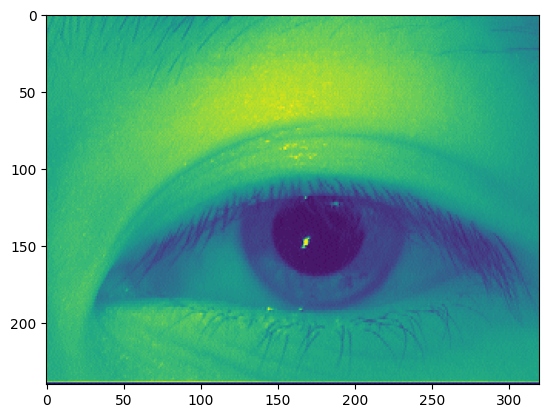

In [11]:
plt.imshow(X_train[0][:,:,2])

## Entrainement du modèle et affichage des performances

In [12]:
from livelossplot import PlotLossesKeras
from keras.callbacks import ReduceLROnPlateau,EarlyStopping
rlrop = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)
early = EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)

In [13]:
from keras.applications.vgg16 import VGG16

from keras.models import Model
from keras.layers import Input, Lambda, Dense, Flatten
NBCLASSES = 45
IMSIZE=[240,320]
def create_model():
    vgg = VGG16(input_shape=IMSIZE + [3], weights='imagenet', include_top=False)
 
    # Freeze existing VGG already trained weights 

    for layer in vgg.layers:
        layer.trainable = False
     
    # get the VGG output
    out = vgg.output
     
    # Add new dense layer at the end
    x = Flatten()(out)
    x = Dense(NBCLASSES, activation='softmax')(x)
     
    model = Model(inputs=vgg.input, outputs=x)
     
    model.compile(loss="categorical_crossentropy",
                  optimizer="adam",
                  metrics=['accuracy'])
     
    model.summary()
     
    return model
 
OG_model = create_model()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 240, 320, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 240, 320, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 240, 320, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 120, 160, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 120, 160, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 120, 160, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 60, 80, 128)       0     

In [14]:

hist = OG_model.fit(np.array(X_train), np.array(y_train_enc), batch_size = 30, epochs = 5, validation_split=0.25,callbacks=[rlrop,early,PlotLossesKeras()])

Epoch 1/5


2023-08-30 14:13:23.896074: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 589824000 exceeds 10% of free system memory.


: 

: 

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Exemple de données de test (remplacez cela par vos propres données)

y_test_pred = [np.argmax(v) for v in OG_model.predict(np.array(X_test))]  # Prédictions du modèle


2/2 [==============================] - 4s 1s/step


Matrice de confusion :
[[1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 1]]
Précision : 0.72
Rappel : 0.76
Score F1 : 0.73
Exactitude : 0.76


c:\Users\ISEN\anaconda3\envs\myenv_170123\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


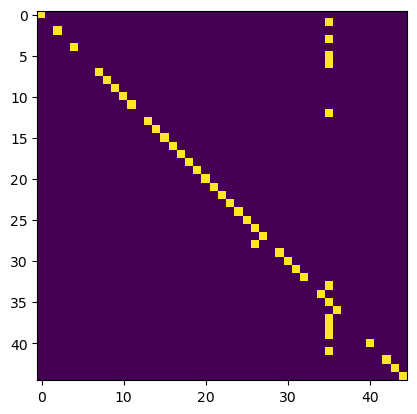

In [ ]:


# Calcul de la matrice de confusion
conf_matrix = confusion_matrix(np.array(y_test), np.array(y_test_pred))

# # Calcul des mesures de performance
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred,average='macro')
recall = recall_score(y_test, y_test_pred,average='macro')
f1 = f1_score(y_test, y_test_pred,average='macro')

print("Matrice de confusion :")
plt.imshow(conf_matrix)
print(conf_matrix)
print("Précision : {:.2f}".format(precision))
print("Rappel : {:.2f}".format(recall))
print("Score F1 : {:.2f}".format(f1))
print("Exactitude : {:.2f}".format(accuracy))

In [ ]:
OG_model.save("vgg16_side_OG2ID_classif")

INFO:tensorflow:Assets written to: vgg16_side_OG2ID_classif\assets


INFO:tensorflow:Assets written to: vgg16_side_OG2ID_classif\assets
